# TP d'OCVX : démélange spectral par moindres carrés et régularisation 

**/!\** Avant de débuter le TP, vous devez avoir lu la petite introduction sur le démélange spectral. Les notations sont les mêmes que dans le document, et les termes spécifiques ne sont pas réintroduits ici.

L'objectif de ce TP est de vous faire manipuler la résolution d'un problème concret (en l'occurrence, le démélange spectral) par méthode des moindres carrés ordinaires, et de vous montrer ce qu'il est possible de faire lorsque le problème est mal posé via les méthodes de régularisation classiques.

Pour le moment, nous n'avons pas le bagage théorique nécessaire à résolution complète du problème de démélange spectral, c'est à dire en intégrant les contraintes de positivité et de somme à 1 pour les abondances. Mais le démélange n'est ici qu'un prétexte, on prendra juste garde à ne pas chercher à interpréter les résultats obtenus pour les abondances en termes de proportions (sauf si vous arrivez à obtenir des abondances positives et sommant à 1 uniquement avec les méthodes abordées dans ce TP, auquel cas, on écrira directement une publication$\dots$)

## I. Introduction

In [3]:
# Les imports de base
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy as sp
from scipy import spatial
import skimage
from skimage import exposure

On commence par importer les données (hsi $=$ *hyperspectral image*), et une vérité terrain (*gt $=$ ground truth*) normalement utilisée pour de la classification (mais elle va nous permettre de générer la matrice d'endmembers $\mathbf{E}$ à moindres frais).

Les données sont de suite normalisées entre 0 et 1 (correspondant à peu près à une conversion radiance $\Rightarrow$ réflectance).

In [4]:
hsi = np.load('data/pavia.npy')
gt = np.load('data/groundtruth.npy')
hsi = hsi/hsi.max() # conversion de la réflectance en radiance
Nrow,Ncol,Nbands = hsi.shape # sera utile plus tard pour les conversions tenseur 3D/matrice
Npix = Nrow*Ncol
print(hsi.shape)

(610, 340, 103)


On vérifie tout de suite les dimensions de l'image : $610$ lignes, $340$ colonnes et $103$ bandes spectrales.


Quelques infos : la scène a été acquise au dessus de l'université de Pavie, en Italie, par le capteur ROSIS 03 (*Reflective Optics System Imaging Spectrometer*). La résolution spatiale du capteur est de $2.6$ m (autrement dit, un pixel couvre une zone de $2.6 \times 2.6$ m au sol). Les $103$ bandes spectrales s'étalent de $430$ nm à $860$ nm, avec une largeur de bande de $4.0$ nm.

Pour visualiser cette image, il va tout d'abord falloir en extraire une image RGB, donc sélectionner un canal de rouge, un canal de vert et un canal de bleu parmi les $103$ bandes spectrales. Pour ce jeu de données, on utiliser en général $R = 47$, $G = 26$ et $B = 10$.

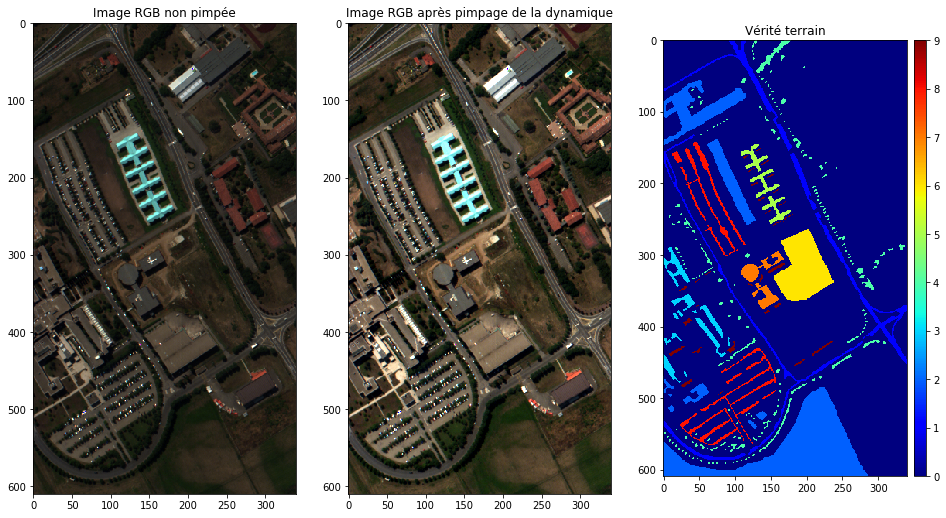

In [5]:
# Par convention, les bandes RGB de cette image sont R=47, G=26 et B=10
hsi_rgb = hsi[:,:,[47,26,10]]

# Réétalonne la dynamique de l'histogramme de chaque bande RGB (étire l'histogramme comprit entre 1% et 99%)
perc = 1
plow, phigh = np.percentile(hsi_rgb, (perc, 100-perc))
pimp_my_hsi_rgb = exposure.rescale_intensity(hsi_rgb, in_range=(plow, phigh))

# Affiche tout ce bazar
plt.figure(figsize=(16,16))
plt.subplot(131)
plt.title('Image RGB non pimpée')
plt.imshow(hsi_rgb)
plt.subplot(132)
plt.imshow(pimp_my_hsi_rgb)
plt.title('Image RGB après pimpage de la dynamique')
plt.subplot(133)
ax = plt.gca()
plt.title('Vérité terrain')
imgt = ax.imshow(gt,cmap='jet')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(imgt, cax=cax)
plt.show()

Pour la vérité terrain ci-dessus, chacune des 9 classes présentent dans l'image est identifiée par un label allant de $1$ à $9$ (la classe $0£ étant, par convention, le fond de l'image). La correspondance des labels avec leur classe sémantique est donné ci-dessous

| label | classe |
|  ---  |   ---  | 
| 1 | Asphalte |
| 2 | Champ/herbe |
| 3 | Gravier |
| 4 | Végétation |
| 5 | Plaques de métal peintes |
| 6 | Sol nu|
| 7 | Bitume |
| 8 | Briques autobloquantes |
| 9 | Ombre |

Plutôt que d'utiliser un algorithme d'induction aveugle d'endmembers ou une bibliothèque spectrale, on va se servir de la vérité terrain pour construire la matrice d'endmembers $\mathbf{E}$.

On va cependant exclure la classe "ombre", qui ne peut pas être considéré comme un constituant macroscopique pur. Pour les classes de $1$ à $8$, on va définir la signature spectral de l'endmember correspondant comme étant le médoïde de tous les pixels appartenant à la classe.

**1.1) Quelle est la différence principale entre le centroïde et le médoïde d'un ensemble de points ? Quel est le principal avantage du médoïde par rapport au centroïde ?**

Le centroide est plus sensible au outliers, il calcule le centre en fonction des extremités.
Le médoïde est déterminé en fonction de tous les points, il est moins sensible aux outliers.

L'algorithme de calcul du médoïde d'un ensemble de points est donné ci-dessous (il n'est pas nécessaire d'essayer de le comprendre)

In [6]:
# vecteur médoïde xmed de X [Nsamples,Nfeatures]
# (pompé sans aucune honte quelque part sur le net)
def geometric_median(X, eps=1e-5):
    y = np.mean(X, 0)

    while True:
        D = sp.spatial.distance.cdist(X, [y])
        nonzeros = (D != 0)[:, 0]

        Dinv = 1 / D[nonzeros]
        Dinvs = np.sum(Dinv)
        W = Dinv / Dinvs
        T = np.sum(W * X[nonzeros], 0)

        num_zeros = len(X) - np.sum(nonzeros)
        if num_zeros == 0:
            y1 = T
        elif num_zeros == len(X):
            return y
        else:
            R = (T - y) * Dinvs
            r = np.linalg.norm(R)
            rinv = 0 if r == 0 else num_zeros/r
            y1 = max(0, 1-rinv)*T + min(1, rinv)*y

        if sp.spatial.distance.euclidean(y, y1) < eps:
            return y1

        y = y1

On peut donc constituer la matrice d'endmembers $\mathbf{E} \in \mathbb{R}^{N_{bands} \times m}$, en récupérant le médoïde de chacune des $m=8$ premières classes de la vérité terrain. $N_{bands}$ étant évidemment le nombre de bandes dans l'image hyperspectrale

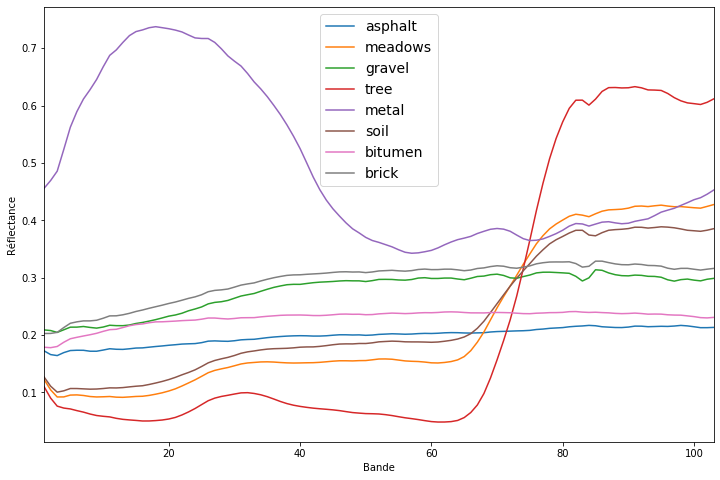

In [7]:
# liste des noms des constituants macroscopiques
endmembers = ['asphalt','meadows','gravel','tree','metal','soil','bitumen','brick']
# m => nombre total d'endmembers considérés
m = len(endmembers)
# E => matrice Nbands x m
E = np.zeros((Nbands,m))
# vectorisation du cube 3D (Nrow x Ncol x Nbands) en matrice (Npix x Nbands)
hsir = hsi.reshape(Npix,Nbands)
# extraction du médoïde pour chaque classe
for c in range(1,m+1): # indice des classes commençant à 1
    class_idx = (gt==c).ravel() # indices vectorisé des pixels appartenant à la classe c
    all_spectra = hsir[class_idx,:] # récupération des spectres correspondants (lignes de la matrice hsir)
    E[:,c-1] = geometric_median(all_spectra) # calcul du médoïde et stockage dans E
    
# On affice les signatures spectrales des 8 endmembers
plt.figure(figsize=(12,8))
for m,em in enumerate(endmembers):
    plt.plot(np.arange(1,104),E[:,m],label=em)
plt.xlim((1,103))
plt.xlabel('Bande')
plt.ylabel('Réflectance')
plt.legend(loc='best',fontsize=14)
plt.show()

## II. Démélange par moindres carrés ordinaires

On attaque maintenant le vif du sujet. Étant donnés la matrice d'endmembers $\mathbf{E} = [\mathbf{e}_1,\dots,\mathbf{e}_m] \in \mathbb{R}^{N_{bands} \times m}$ et le spectre $\mathbf{x} \in \mathbb{R}^{N_{bands}}$ d'un pixel, on veut récupérer les abondances fractionnelles $\boldsymbol \phi = [\phi_1,\dots,\phi_m]$ de $\mathbf{x}$.

D'après le LMM, $\mathbf{x}$ s'écrit comme la combinaison linéaire des endmembers $\mathbf{e}_i$ pondérés par leur abondance fractionnelle $\phi_i$ correspondante (plus un bruit additif indépendant pour modéliser les imprefections du modèle) :
$$ \mathbf{x} = \sum_{i=1}^m \phi_i \mathbf{e}_i + \boldsymbol \eta = \mathbf{E} \boldsymbol \phi + \eta$$

L'inversion de ce modèle revient à calculer le vecteur $\boldsymbol \phi$ qui minimise la _residual sum of squares_ $RSS(\boldsymbol \phi) = \displaystyle \sum_{i=1}^{N_{bands}} \big(x(i) - [\mathbf{E}\boldsymbol \phi](i)\big)^2 = \|\mathbf{x} -  \mathbf{E}\boldsymbol \phi \|_2^2$ :

$$ \boldsymbol \phi = \arg\min_{\boldsymbol \phi \in \mathbb{R}^m} = \|\mathbf{x} -  \mathbf{E}\boldsymbol \phi \|_2^2 \quad (1)$$

**2.1) Retrouver analytiquement la solution du problème (1).**

Il s'agira d'exprimer $\boldsymbol \phi$ en fonction de $\mathbf{E}$ et $\mathbf{x}$.

Vous devez coder la solution analytique vous même dans un premier temps. Ce n'est que dans un second temps que vous pourrez vous rassurer (ou pas) en vérifiant que vous obtenez bien la même chose qu'un solveur de moindres carrés ordinaires.

Démélangez dans un premier temps des spectres appartenant à l'une des 8 classes.

Pour trouver le minimum de $(1)$ il faut trouver la valeur de $\phi$ lorsque le gradient de $(1)$ est nul.

$$\nabla RSS(\phi) = \nabla||x-E\phi||_2^2$$
$$\nabla RSS(\phi) = -2E^T.(x-E\phi)$$
Sachant que  $\nabla RSS(\phi)=0$
$$-2E^T.(x-E\phi)=0$$
$$-2E^Tx + 2(E^T.E\phi) = 0$$
$$E^T.E\phi = E^Tx $$
$$\phi = (E^T.E)^{-1}E^Tx $$

In [8]:
def least_square(x, E):
    phi = (np.linalg.inv(E.T @ E) @ E.T) @ x
    return phi

x = hsir[3666, :]

phi = least_square(x, E)

print(f"Moindres carrés de Numpy:\n{np.linalg.lstsq(E, x, rcond=None)[0]}")
print(f"Nos résultats:\n{phi}")

Moindres carrés de Numpy:
[ 3.61497223 -0.40455608 -2.43186151  0.57646307  0.03767148  0.56170703
 -3.17983735  2.55097112]
Nos résultats:
[ 3.61497223 -0.40455608 -2.43186151  0.57646307  0.03767148  0.56170703
 -3.17983735  2.55097112]


**2.2) En théorie, quelle devrait être la composition du vecteur d'abondances $\boldsymbol \phi$? Et qu'en est-il en pratique ? Comparez graphiquement le spectre initial $\mathbf{x}$ avec sa reconstruction $\hat{\mathbf{x}} = \mathbf{E}\boldsymbol \phi$**

In [9]:
def reconstruct(E,res):
    return E @ res

x_res = reconstruct(E, phi)

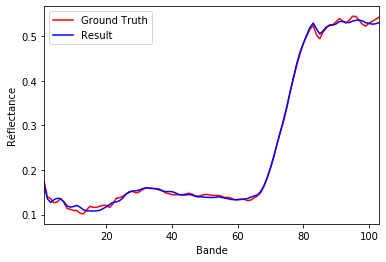

In [10]:
def compare_pixel(pix, pix_res, show=True):
    plt.plot(np.arange(1,104),pix, 'r', label='Ground Truth')
    plt.plot(np.arange(1,104),pix_res, 'b', label='Result')
    plt.xlim((1,Nbands))
    plt.xlabel('Bande')
    plt.ylabel('Réflectance')
    plt.legend()
    if show:
        plt.show()
compare_pixel(x, x_res)

en Théorie  $\boldsymbol \phi$ = x / E

en Pratique  $\boldsymbol \phi$ = x / E + biais, on a une perte d'information qu'on peut constater via à aux courbes ci-dessous qui ne sont tout à fait superposées

Il est coutûme de mesurer quantitativement la qualité de démélange de $\mathbf{x}$ par l'erreur quadratique moyenne entre $\mathbf{x}$ et sa reconstruction $\mathbf{\hat{x}} = \sum_{i=1}^m \phi_i \mathbf{e}_i$ :

$$\epsilon(\mathbf{x},\mathbf{\hat{x}}) = \sqrt{\frac{1}{N_{bands}} \sum_{i=1}^{N_{bands}} (x(i) - \hat{x}(i))^2} \quad (2)$$

**2.3) Implémentez la fonction d'erreur quadratique moyenne. Quel ordre de grandeur obtenez vous pour les spectres démélangées précédemment ?**

In [11]:
def MeanSquareError(x, x_bis):
    res = 0
    for i in range(Nbands):
        res = res + (x[i] - x_bis[i])**2
    return np.sqrt((1/Nbands)*res)

print(MeanSquareError(x, x_res))

0.005348894872902987


L'ordre de grandeur obtenu est environ de 10e-2 pour le spectre démélangée précédemment.

Démélanger pixel par pixel, c'est bien. Mais s'il était possible d'obtenir d'un coup les abondances fractionnelles de tous les pixels de l'image, ça serait vachement mieux. Et ça tombe bien, car c'est possible : il suffit d'utiliser la modélisation matricielle de l'image hyperspectrale $\mathbf{X} \in \mathbb{R}^{N_{bands} \times N_{pix}}$ et d'étendre le problème (1) sous la forme 

$$\boldsymbol \Phi = \arg\min_{\Phi \in \mathbb{R}^{m\times N_{pix}}} = \|\mathbf{X} -  \mathbf{E}\Phi \|_2^2 \quad (1)$$

La solution $\boldsymbol \Phi \in \mathbb{R}^{m\times N_{pix}}$ obtenue s'interprète donc comme une matrice d'abondances fractionnelles, où chaque colonne contient le vecteur d'abondance $\boldsymbol \phi$ du pixel correspondant. Cette matrice peut se réorganiser à moindres frais en un cube 3D $(N_{row} \times N_{col} \times m)$, où chaque canal peut se visualiser comme la carte d'abondances fractionelles de l'image entière pour l'endmember considéré.

**2.4) Adaptez votre implémentation de la question 2) pour obtenir la matrice d'abondance $\boldsymbol \Phi$ en un coup**

In [12]:
def total_rss(X, E):
    phi = (np.linalg.inv(E.T @ E) @ E.T) @ X.T
    return np.swapaxes(phi, 0, 1)

def normalize(X):
    return (X - np.amin(X, 0)) / (np.amax(X, 0) - np.amin(X, 0))

phi_arr = total_rss(hsir, E)

**2.5) Réorganisez la matrice précédente en un cube 3D et visualisez les différentes cartes d'abondances pour les 8 endmembers. Que remarquez vous/pouvez vous en conclure ?**

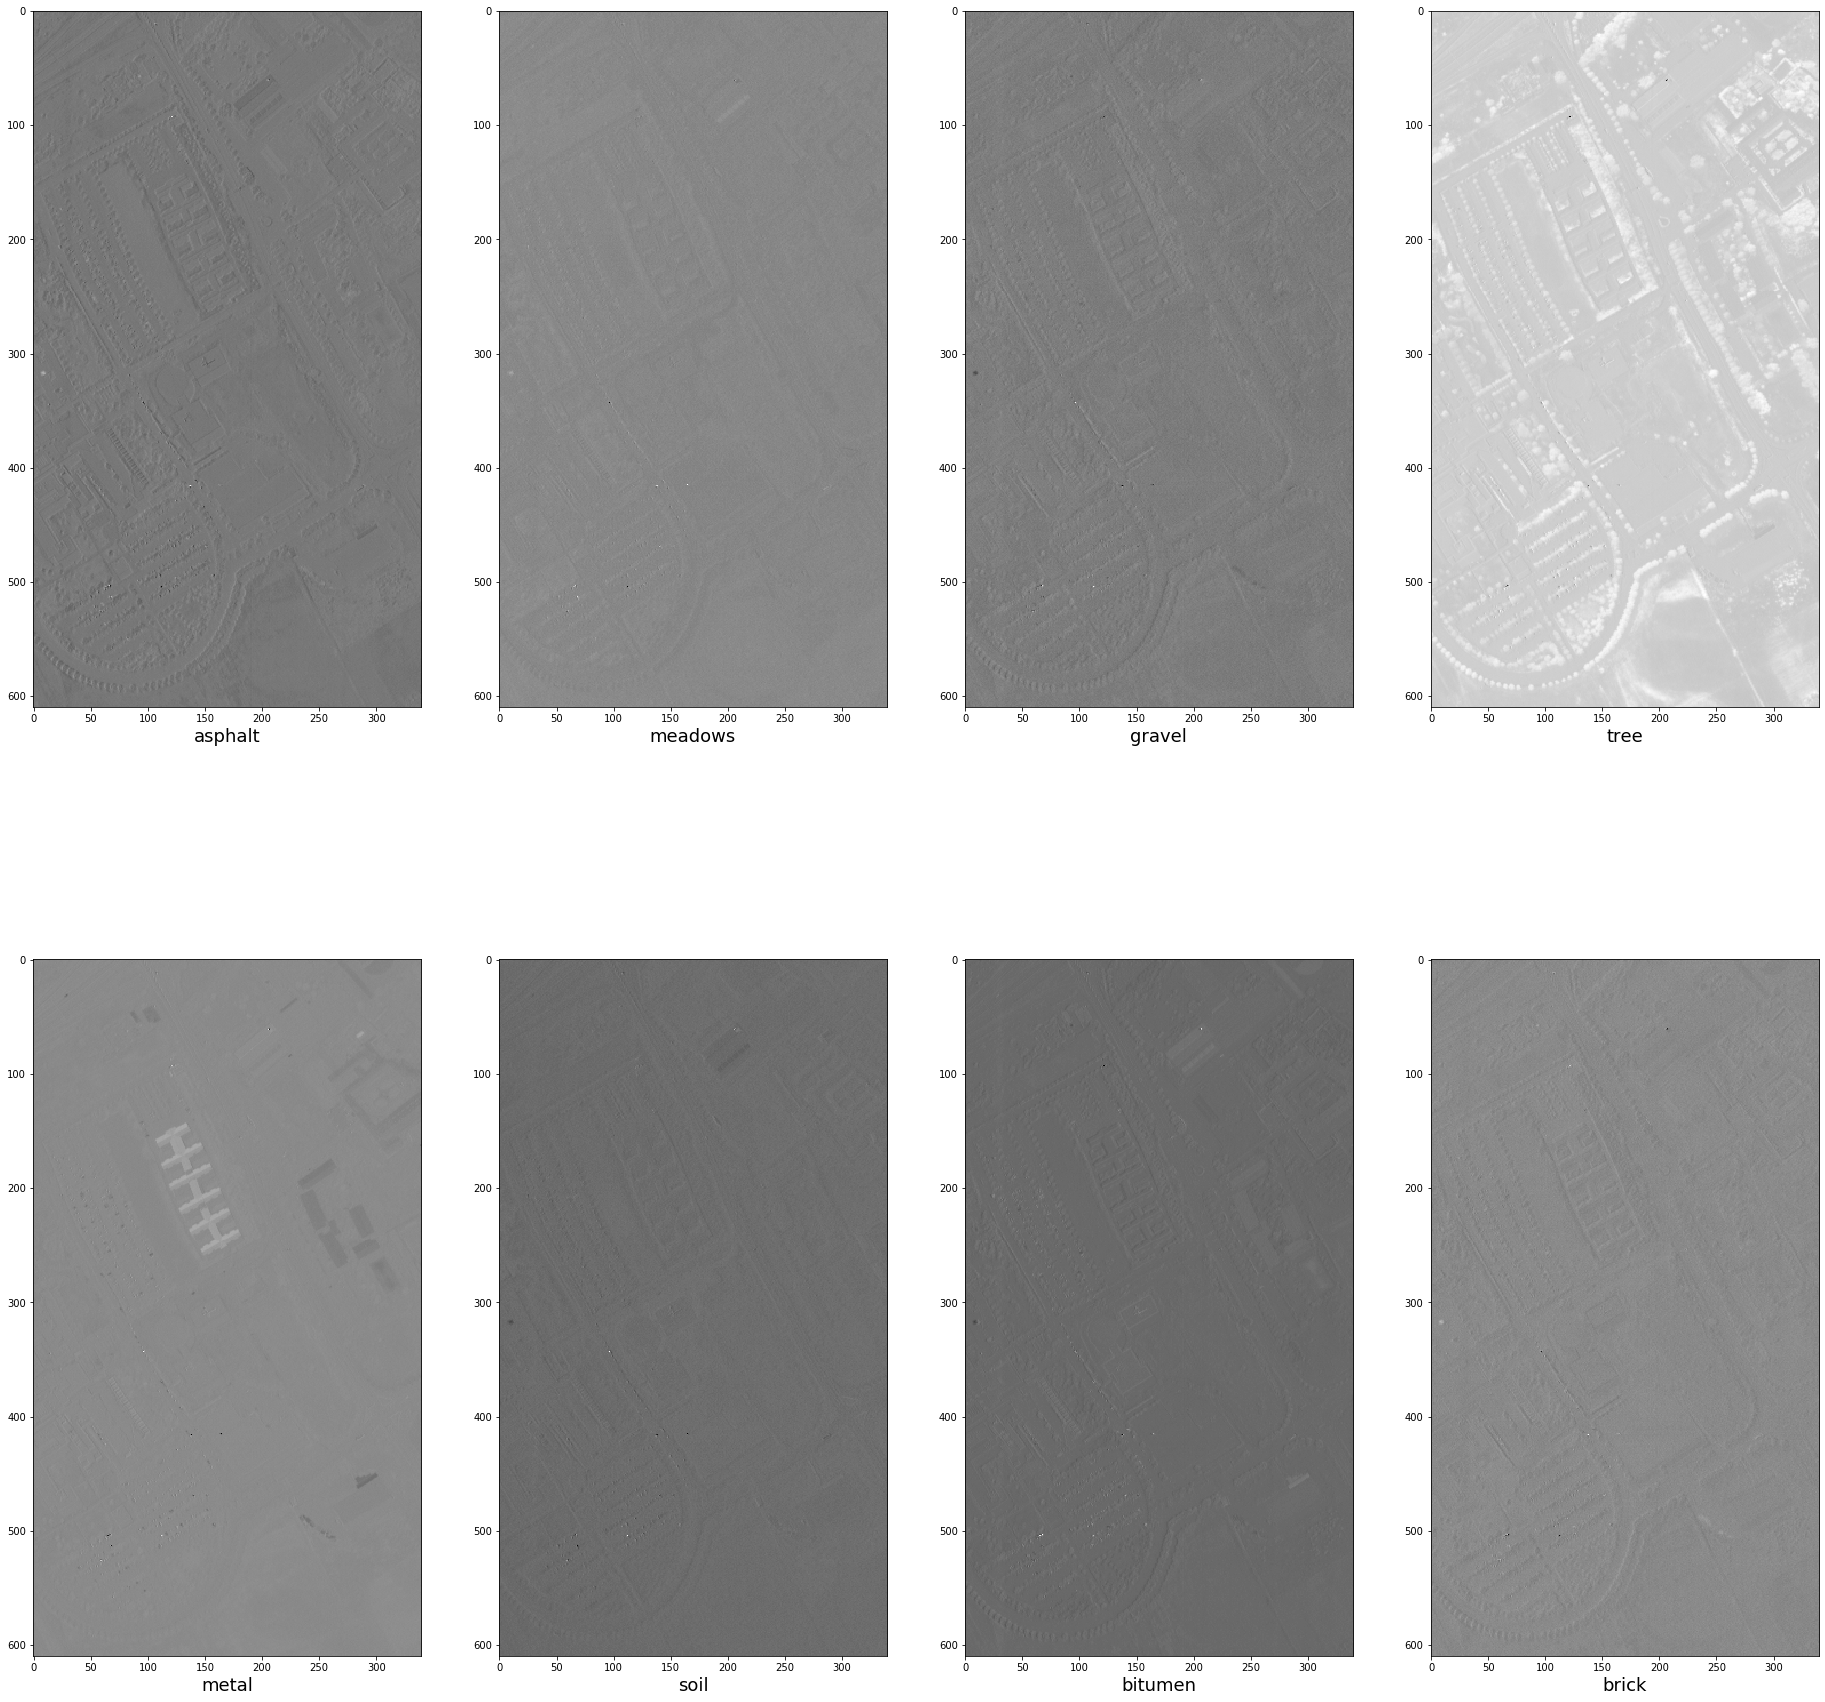

In [13]:
imgs = np.reshape(phi_arr, (Nrow, Ncol, 8))
plt.figure(figsize=(32,32))
for i in range(8):
    plt.subplot(241 + i)
    plt.imshow(imgs[:, :, i], cmap="gray")
    plt.xlabel(endmembers[i], fontsize=18)

Nous pouvons remarquer que pour les 8 endmembers, chaque pixel n'est pas pur et qu'il contient un peu de ces endmembers ce que va rendre plus difficile la classification.

Tout comme l'équation (1) peut se reformuler pour obtenir une solution matricielle (la matrice $\boldsymbol \Phi$), il est possible d'obtenir d'un coup l'erreur quadratique moyenne de l'image entière $\epsilon(\mathbf{X},\mathbf{\hat{X}} = \mathbf{E}\boldsymbol \Phi)$ (plutôt que de boucler sur tous les pixels).

**2.6) Visualisez la carte d'erreur quadratique moyenne de l'image hyperspectral pour le démélange obtenu**

In [14]:
def reconstruct_img(phi_arr, E):
    return np.swapaxes(E @ phi_arr.T, 0, 1)

def MeanSquareErrorImg(hsir, res):
    l = hsir.shape[0]
    mean = np.zeros(l)
    for i in range(l):
        mean[i] = MeanSquareError(hsir[i], res[i])
    return mean

X_res = reconstruct_img(phi_arr, E)
square_error_map = MeanSquareErrorImg(hsir, X_res)
print("Square Error map: ", square_error_map)
print("Square Error Total:", np.mean(square_error_map))
print("Square Error map shape: ", square_error_map.shape)

Square Error map:  [0.00562016 0.0045401  0.00851137 ... 0.00458358 0.00695516 0.00522779]
Square Error Total: 0.0074027812352192275
Square Error map shape:  (207400,)


On pourrait imaginer une stratégie de classification (naïve) suivante : chaque pixel est classifié selon son abondance fractionnelle majoritaire (puisqu'en théorie, plus l'abondance fractionelle est proche de $1$, plus le matériau correspondant est présent dans la signature spectrale du pixel en question). Même si le démélange obtenu précédemment avec les moindres carrés ordinaires devrait laisser à penser que cette stratégie est vouée à l'échec, on peut quand même y jeter un oeil.

Elle pourrait avoir particulièrement du sens pour les pixels supposés "purs", c'est à dire tous les pixels de la vérité terrain dont le label est compris entre $1$ et $8$ (les pixels labelisés $0$ sont de classe inconnue du point de vue de la classification, et les pixels labelisés $9$ correspondant à de l'ombre (d'un autre matériau), ils ne sont pas purs non plus).

**2.7) Appliquez la stratégie de classification évoquée juste au dessus, à savoir que chaque pixel est classifié selon son abondance fractionnelle majoritaire, et visualisez la carte de classification obtenue. Que pouvez vous en conclure ?**

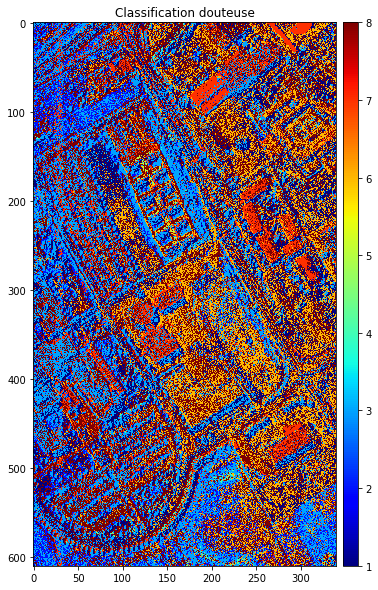

In [15]:
# change img to be like gt map
def to_balel(img_3d):
    labelled = np.zeros((Nrow, Ncol))
    for y in range(Nrow):
        for x in range(Ncol):
            labelled[y, x] = np.argmax(img_3d[y, x]) + 1
    return labelled
labelled = to_balel(imgs)


plt.figure(figsize=(10,10))
ax = plt.gca()
plt.title('Classification douteuse')
imgt = ax.imshow(labelled,cmap='jet')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(imgt, cax=cax)
plt.show()

L'évaluation qualitative précédente permet de donner des billes sur ce qui marche et ce qui ne marche pas à propos de la stratégie de classification appliquée. Mais cette évaluation qualitative doit être complétée par une évaluation quantitative plus rigoureuse, par le biais des métriques classiques de classification que vous connaissez.

**2.8) Complétez votre analyse précédente par une évaluation quantitative : taux de bonne classification globale, matrice de confusion et taux de bonne classification par classe**

In [16]:
def taux_globale(res, gt):
    good_class = 0
    nb = 207400
    for i in range(610):
        for j in range(340):
            if gt[i,j] == 0 or gt[i,j] == 9:
                nb -=1
            elif gt[i,j] == res[i,j]:
                good_class +=1
    return good_class / nb
good_cl = taux_globale(labelled,gt)
print('Taux global: {0}'.format(good_cl))

Taux global: 0.2849697578235196


In [17]:
def rateClassClassification(gt, res):
    #res = 0
    np_class = np.zeros(8)
    nb_class = np.zeros(8)
    for i in range(610):
        for j in range(340):
            if (gt[i, j] == res[i, j]):
                np_class[gt[i, j] - 1] += 1
            if (gt[i, j] != 0 and gt[i, j] != 9):
                nb_class[gt[i, j] - 1] += 1
    np_class = np_class / nb_class
    return np_class
    
print('Taux de bonne classification par classe :\n{0}'.format(rateClassClassification(gt, labelled)))

Taux de bonne classification par classe :
[0.27069824 0.23556223 0.53454026 0.08746736 0.14423792 0.33903361
 0.37969925 0.52634438]


In [18]:
from sklearn.metrics import confusion_matrix

gt_reshape = gt.reshape(-1, 1)
res_reshape = labelled.reshape(-1, 1)
print('Matrice de confusion :\n {0}'.format(confusion_matrix(gt_reshape, res_reshape)))

Matrice de confusion :
 [[    0 32121  8345 36515   697    37 26931 13703 46275     0]
 [    0  1795   141  1607     0     0   766   435  1887     0]
 [    0  1556  4393  5066   172     0  2357   585  4520     0]
 [    0    94    42  1122     0     0    26    55   760     0]
 [    0   357   221   721   268     0   280   346   871     0]
 [    0   161    29   292     0   194   130   164   375     0]
 [    0   400   197   844     1     0  1705   149  1733     0]
 [    0    52     3   227     0     0    50   505   493     0]
 [    0    75    16  1094     0     0   403   156  1938     0]
 [    0   419     5   486     0     0     7     0    30     0]]


## III. Régularisation de Tikhonov

Les techniques de régularisation sont très souvent utilisés pour la résolution de problèmes mal posés. Pour des problèmes linéaires sur-déterminés, c'est à dire du type $\mathbf{A}\mathbf{x} = \mathbf{b}$, où la matrice $\mathbf{A}$ possède plus de lignes que de colonnes - c'est notre cas ici - la régularisation va se matérialiser comme l'ajout d'un second terme $\mathcal{R}(\mathbf{x})$ au $RSS(\mathbf{x}) = \| \mathbf{A}\mathbf{x} - \mathbf{b}\|_2^2 $ :

$$ RSS \text{ avec régularisation : }  \| \mathbf{A}\mathbf{x} - \mathbf{b}\|_2^2 + \mathcal{R}(\mathbf{x}), \quad (3)$$

de manière à ce que la solution de ce problème d'optimisation retrouver des propriétés souhaitables (de stabilité par exemple, c'est-à-dire qu'une légère perturbation de l'entrée n'entraine qu'une légère perturbation de la sortie, ce qui n'est pas le cas sans régularisation si $\mathbf{A}$ est mal conditionnée.

Le choix du terme de régularisation $\mathcal{R}(\mathbf{x})$ va bien sûr influer sur ces propriétés et sur la manière de résoudre le problème (3).

Dans le cas de la régularisation de Tikhonov, le terme de régularisation (aussi appelé _pénalité_) s'exprime comme $\mathcal{R}(\mathbf{x}) = \lambda \| \boldsymbol \Gamma \mathbf{x}\|_2^2$, où $\boldsymbol \Gamma$ (appelé matrice de Tikhonov) est déterminé en fonction du problème, et où $\lambda$ permet de donner plus où moins de poids à la régularisation par rapport au RSS.

Dans notre cas de démélange, $\boldsymbol \Gamma$ sera choisi comme la matrice identité, de manière à ce qu'on puisse réécrire le problème d'optimisation (en reprenant nos notations précédentes) : 

$$ \arg\min_{\boldsymbol \phi \in \mathbb{R}^m} = \|\mathbf{x} -  \mathbf{E}\boldsymbol \phi \|_2^2 + \lambda \|\boldsymbol \phi \|_2^2\quad (4)$$

Ainsi, le terme de régularisation, en pénalisant les solutions ayant des composantes importantes (en valeur absolue), aura tendance à privilégier des solutions $\boldsymbol \phi$ dont la norme euclidienne est faible. La valeure de $\lambda$ permettra de jouer sur le degré de régularisation (et donc la liberté qu'aura $\boldsymbol \phi$ d'avoir des entrées de magnitude élevée) : plus $\lambda$ sera élevé, et plus la régularisation sera importante.

Sans surprise, le but de cette partie va être d'étudier l'influence de la régularisation de Tikhonov sur le problème d'estimation des abondances, et la comparaison avec la méthode des moindres carrés ordinaires. IL s'agira donc ici de reproduire ce qui a été fait dans la partie II, tout en intégrant l'étude de l'influence de $\lambda$ sur la qualité du démélange

**3.1) Dérivez sur papier la solution analytique du problème (4)** 

1.   Élément de liste
2.   Élément de liste

(car oui, elle existe, et elle est pas tellement plus compliquée que la solution des moindres carrés ordinaires)

On utilise la meme technique que pour les moindres carrés utilisées dans la question $2.1$

$$\nabla RSS(\phi) = \nabla(||x-E\phi||_2^2 + \lambda||\phi||_2^2)$$
$$\nabla RSS(\phi) = -2E^T.(x-E\phi) + 2\lambda\phi$$
Sachant que  $\nabla RSS(\phi)=0$
$$-2E^T.(x-E\phi) + 2\lambda\phi =0$$
$$-2E^Tx + 2(E^T.E\phi) = 0$$
$$E^T.E\phi + \lambda\phi= E^Tx $$
$$(E^T.E + \lambda)\phi= E^Tx $$
$$\phi = (E^T.E + \lambda)^{-1}E^Tx $$

**3.2) Implémentez le démélange avec régularisation de Tikhonov pour quelques spectres de l'image. Que remarquez vous qualitativement (comparaison de la signature originelle $\mathbf{x}$ avec la signature reconstruite) et quantitativement (valeur de l'erreur quadratique moyenne) par rapport aux solutions obtenues par moindres carrés ordinaires ? L'influence de $\lambda$ est elle bien conforme à celle prédite par la théorie ?**

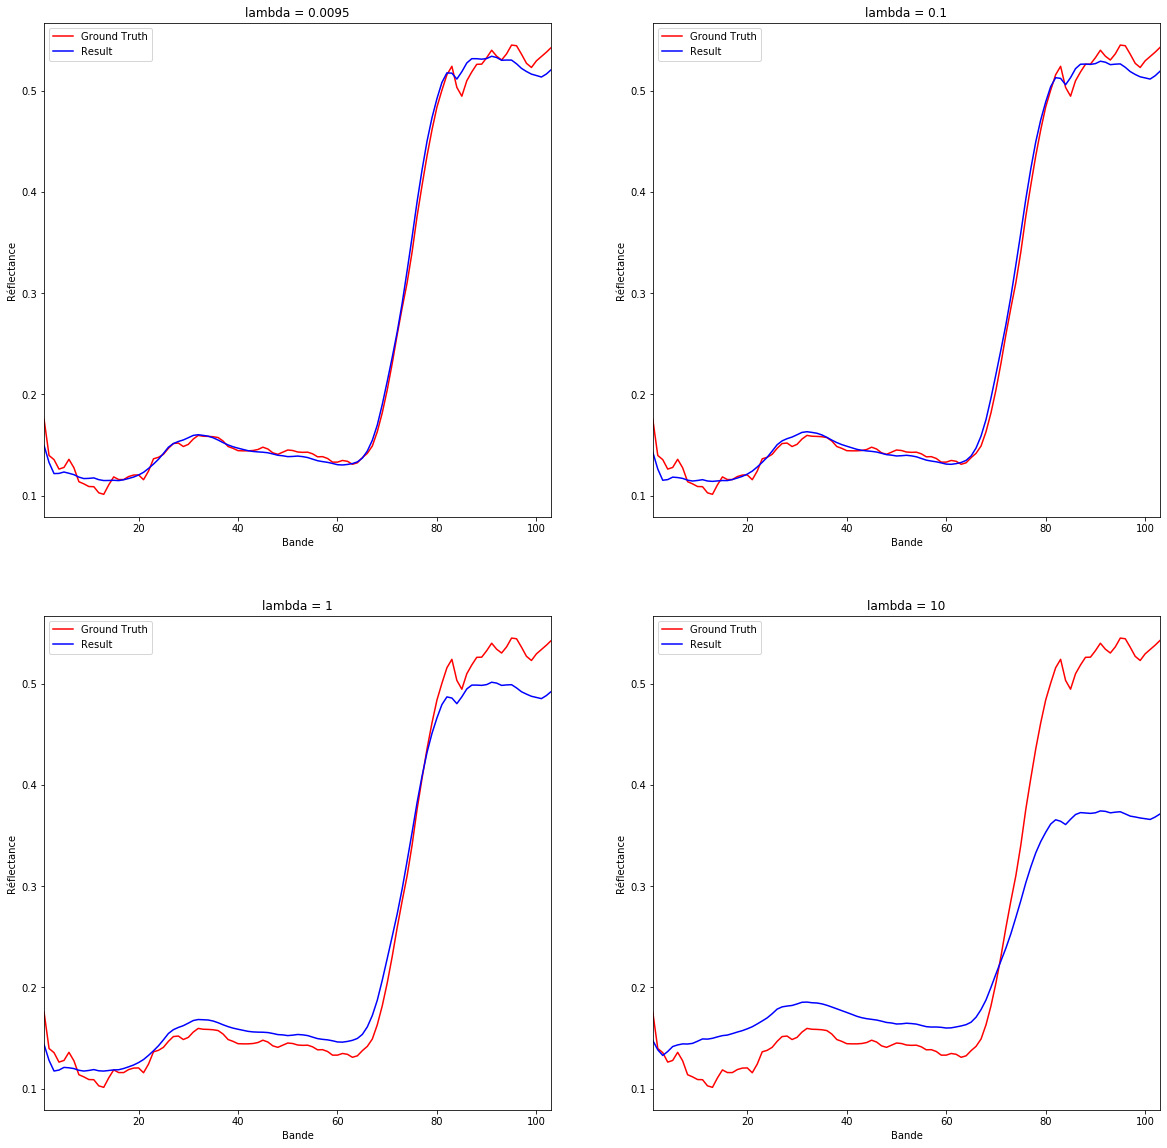

In [19]:
def one_tikhonov(X, E, lba):
    tikho = lba * np.identity(E.shape[1])
    phi = (np.linalg.inv(E.T @ E + tikho) @ E.T) @ X
    return phi





tik_0 = one_tikhonov(hsir[3666,:], E, 0.0095)
tik_1 = one_tikhonov(hsir[3666,:], E, 0.1)
tik_2 = one_tikhonov(hsir[3666,:], E, 1)
tik_3 = one_tikhonov(hsir[3666,:], E, 10)

rec_0 = E @ tik_0
rec_1 = E @ tik_1
rec_2 = E @ tik_2
rec_3 = E @ tik_3


plt.figure(figsize=(20, 20))
plt.subplot(221)
compare_pixel(hsir[3666, :], rec_0, False)
plt.title('lambda = 0.0095')
plt.subplot(222)
compare_pixel(hsir[3666, :], rec_1, False)
plt.title('lambda = 0.1')
plt.subplot(223)
compare_pixel(hsir[3666, :], rec_2, False)
plt.title('lambda = 1')
plt.subplot(224)
compare_pixel(hsir[3666, :], rec_3, False)
plt.title('lambda = 10')
plt.show()

In [20]:
print("Mean square error for lambda = 0.0095: ", MeanSquareError(hsir[3666,:], rec_0))
print("Mean square error for lambda = 0.1: ", MeanSquareError(hsir[3666,:], rec_1))
print("Mean square error for lambda = 1: ", MeanSquareError(hsir[3666,:], rec_2))
print("Mean square error for lambda = 10: ", MeanSquareError(hsir[3666,:], rec_3))

Mean square error for lambda = 0.0095:  0.008576483738769895
Mean square error for lambda = 0.1:  0.009983585656156854
Mean square error for lambda = 1:  0.020281376786898356
Mean square error for lambda = 10:  0.08182484820400913


Nous pouvons remarquer que la reconstruction du signal est assez fiable. De plus l'erreur quadratique moyenne est de 0.008
pour un lambda de 0.0095. Nous observons que l'influence de lambda est bien conforme a celle prédite. C'estt à dire plus 
le lambda est élevé plus il y'a une régularisation (un lissement de la courbe).

**3.3) Vérifiez que vous retrouver bien la même solution que les solveurs classiques de ce problème de régularisation** (si vous voulez passer par une bibliothèque de *machine learning*, vous trouverez la solution du problème (4) sous son autre appelation, à savoir "régression Ridge").

In [21]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

def one_modelRidge(E, x, alpha):
    r_model = Ridge(alpha=alpha,fit_intercept=False)
    r_model.fit(E, x)
    y = r_model.predict(E)
    return y, r_model.coef_

def demelangeTikhonov(E, hsir, alpha=1.0):
    model = Ridge(alpha)
    model.fit(E, np.transpose(hsir))
    y = model.predict(E)
    return y, model.intercept_


y, coef = one_modelRidge(E, hsir[3666,:], 0.0095)
y1, coef1 = one_modelRidge(E, hsir[3666,:], 0.1)
y2, coef2 = one_modelRidge(E, hsir[3666,:], 1.0)
y3, coef3 = one_modelRidge(E, hsir[3666,:], 10)
# plt.figure(figsize=(32,10))
# plt.figure(figsize=(20, 20))
# plt.subplot(221)
# compare_pixel(hsir[3666, :], y, False)
# plt.title('lambda = 0.0095')
# plt.subplot(222)
# compare_pixel(hsir[3666, :], y1, False)
# plt.title('lambda = 0.1')
# plt.subplot(223)
# compare_pixel(hsir[3666, :], y2, False)
# plt.title('lambda = 1')
# plt.subplot(224)
# compare_pixel(hsir[3666, :], y3, False)
# plt.title('lambda = 10')
# plt.show()

# mse = MeanSquareError(x, y)

print("Matrix of coef compute with solver for the pixel 3666 with lambda=0.0095: \n", coef)
print("Matrix of coef compute with our function for the pixel 3666 with lambda=0.0095: \n", tik_0)
print("Nous pouvons constater que nous obtenu bien les deux même matrice avec notre fonction et un solveur classique de Tikhonov.")
#print('valeur de l\'erreur quadratique moyenne pour alpha = 1.0 : {0}'.format(mse))


#print('On peut constater que plus le landa augmente plus la régularisation est élevée')


Matrix of coef compute with solver for the pixel 3666 with lambda=0.0095: 
 [ 0.23817929  0.10077507  0.05467268  0.60843497  0.01330317  0.08328132
  0.03010808 -0.02106469]
Matrix of coef compute with our function for the pixel 3666 with lambda=0.0095: 
 [ 0.23817929  0.10077507  0.05467268  0.60843497  0.01330317  0.08328132
  0.03010808 -0.02106469]
Nous pouvons constater que nous obtenu bien les deux même matrice avec notre fonction et un solveur classique de Tikhonov.


**3.4) Idem que pour les moindres carrés ordinaires, adaptez votre implémentation pour obtenir d'un coup la matrice d'abondances $\boldsymbol \Phi$ pour toute l'image. Affichez ces cartes d'abondances fractionnelles et la carte d'erreur quadratique moyenne de reconstruction pour l'image entière. Qu'en est-il de l'influence de $\lambda$ ?**

Square Error Total with lambda=0.0095:  0.0104869021257814
Square Error Total with lambda=0.1:  0.012593587437314643
Square Error Total with lambda=1:  0.022165214365451325
Square Error Total with lambda=10:  0.06343088709416471


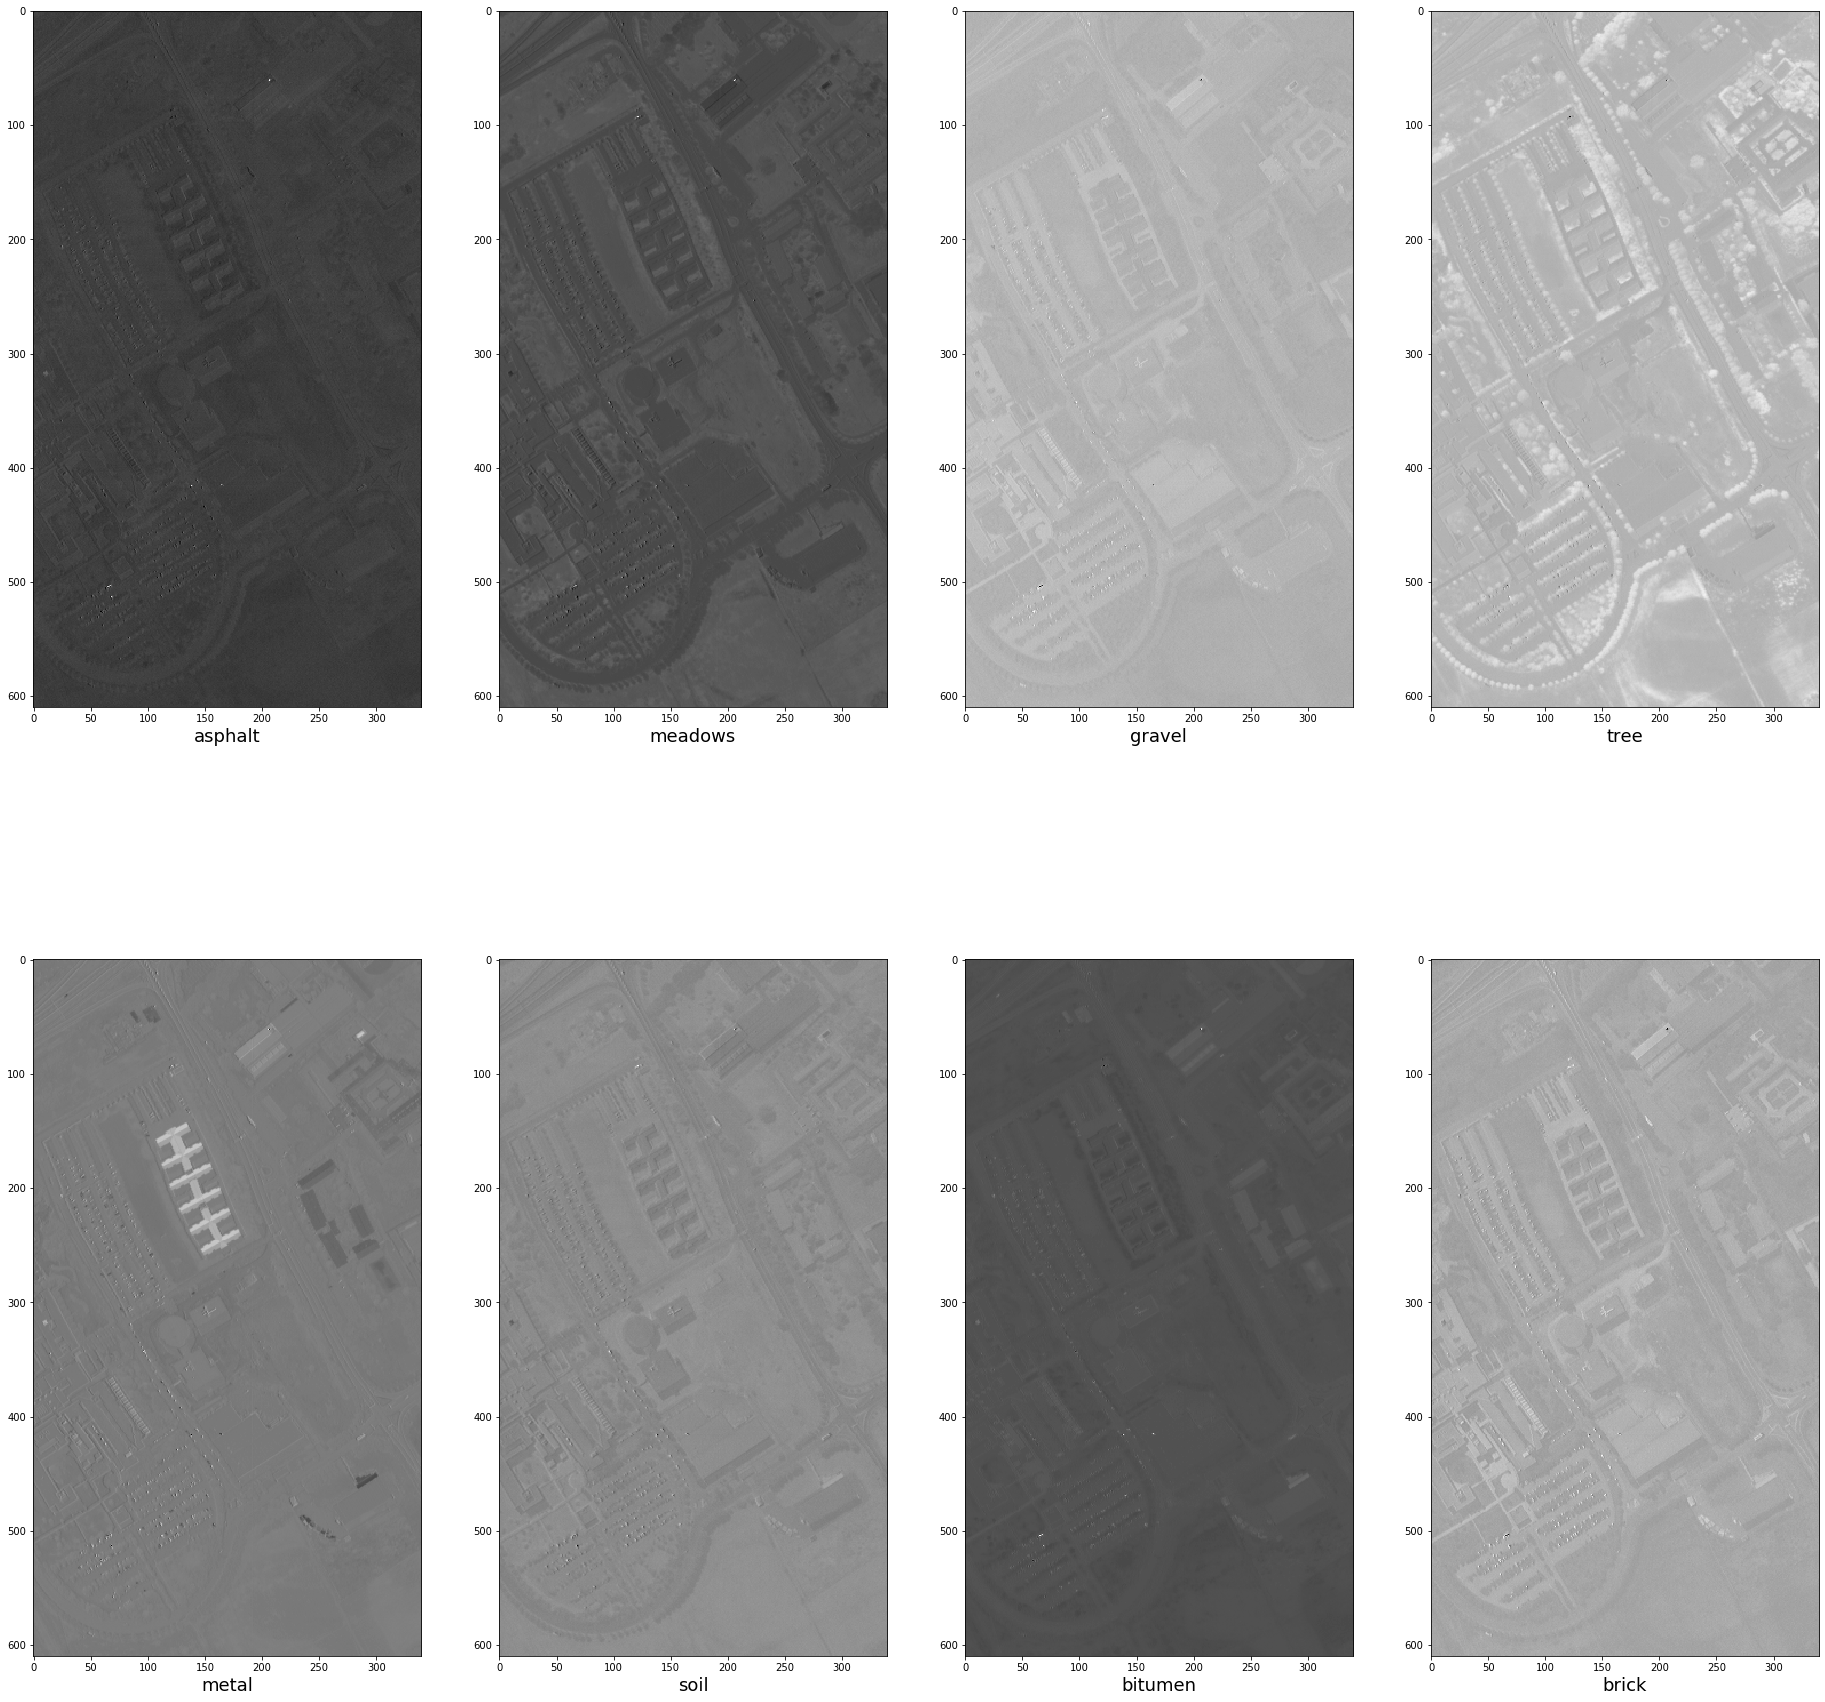

In [22]:
def tikhonov(X, E, lba):
    tikho = lba * np.identity(E.shape[1])
    phi = (np.linalg.inv(E.T @ E + tikho) @ E.T) @ X.T
    return np.swapaxes(phi, 0, 1)

tik0 = tikhonov(hsir, E, 0.0095)
tik1 = tikhonov(hsir, E, 0.1)
tik2 = tikhonov(hsir, E, 1)
tik3 = tikhonov(hsir, E, 10)

rec0 = reconstruct_img(tik0,E)
rec1 = reconstruct_img(tik1,E)
rec2 = reconstruct_img(tik2,E)
rec3 = reconstruct_img(tik3,E)

print("Square Error Total with lambda=0.0095: ", MeanSquareErrorImg(hsir, rec0).mean())
print("Square Error Total with lambda=0.1: ", MeanSquareErrorImg(hsir, rec1).mean())
print("Square Error Total with lambda=1: ", MeanSquareErrorImg(hsir, rec2).mean())
print("Square Error Total with lambda=10: ", MeanSquareErrorImg(hsir, rec3).mean())
# Afficher les cartes d'abondances

imgs = np.reshape(tik0, (Nrow, Ncol, 8))
plt.figure(figsize=(32,32))
for i in range(8):
    plt.subplot(241 + i)
    plt.imshow(imgs[:, :, i], cmap="gray")
    plt.xlabel(endmembers[i], fontsize=18)

On peux clairement voir l'influence de lambda sur les performances de Tikhonov grâce aussi avec l'erreur quadratique moyenne.

**3.5) Ré-appliquez la stratégie de classification du point 2.7) précédent, et étudiez les résultats qualitativement et quantitativement (toujours en fonction de $\lambda$). Quel est l'influence de la régularisation de Tikhonov sur les performances de classification ?**

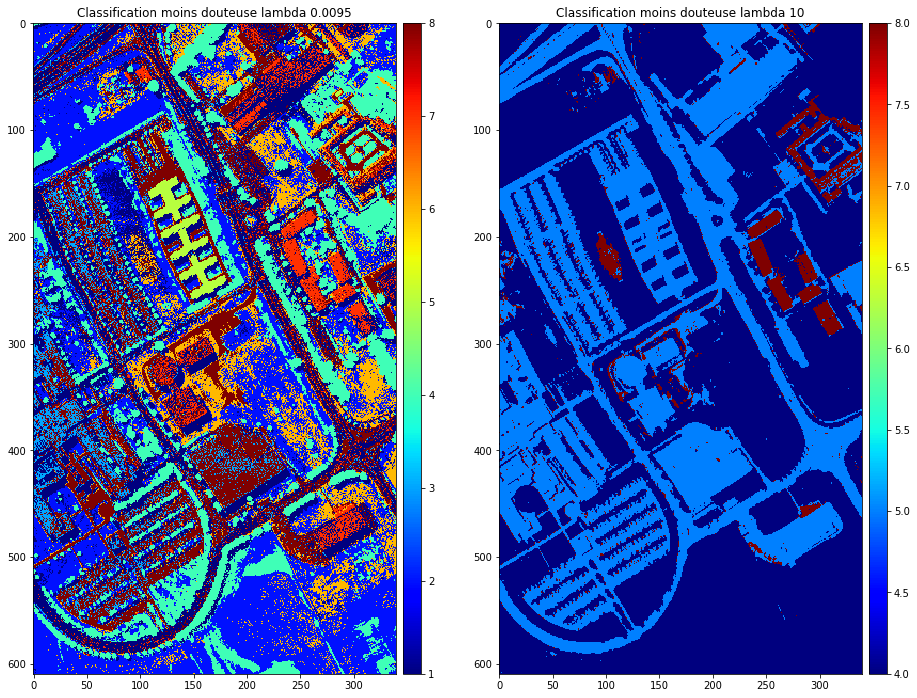

In [23]:
imgs = np.reshape(tik0, (Nrow, Ncol, 8))
labelled = to_balel(imgs)
### AJOUTER AUSSI LES tik1 tik2 tik3 POUR COMPARER LES LAMBDA
plt.figure(figsize=(32,32))
plt.subplot(241)
ax = plt.gca()
plt.title('Classification moins douteuse lambda 0.0095')
imgt = ax.imshow(labelled,cmap='jet')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(imgt, cax=cax)

plt.subplot(242)

imgs = np.reshape(tik3, (Nrow, Ncol, 8))
labelled = to_balel(imgs)
ax = plt.gca()
plt.title('Classification moins douteuse lambda 10')
imgt = ax.imshow(labelled,cmap='jet')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(imgt, cax=cax)
plt.show()

In [24]:
good_cl = taux_globale(labelled,gt)
print('Taux global: {0}'.format(good_cl))
print('Taux de bonne classification par classe :\n{0}'.format(rateClassClassification(gt, labelled)))
gt_reshape = gt.reshape(-1, 1)
res_reshape = labelled.reshape(-1, 1)
print('Matrice de confusion : \n{0}'.format(confusion_matrix(gt_reshape, res_reshape)))

Taux global: 0.10581175739319611
Taux de bonne classification par classe :
[0.         0.         0.         0.99836815 1.         0.
 0.         0.00597501]
Matrice de confusion : 
[[     0      0      0      0 100045  57121      0      0   7458      0]
 [     0      0      0      0     45   6544      0      0     42      0]
 [     0      0      0      0  18112     54      0      0    483      0]
 [     0      0      0      0      3   2085      0      0     11      0]
 [     0      0      0      0   3059      3      0      0      2      0]
 [     0      0      0      0      0   1345      0      0      0      0]
 [     0      0      0      0   4038    793      0      0    198      0]
 [     0      0      0      0      2   1322      0      0      6      0]
 [     0      0      0      0     24   3636      0      0     22      0]
 [     0      0      0      0    434    512      0      0      1      0]]


Avec un lambda de 0.0095, cela donne un taux global de classification de 70% correcte, alors qu'avec les moindres carrés cela nous donne seulement 28%. Cela peut s'expliquer car Tikhonov lisse la courbe. De plus nous pouvons remarquer que le lambda influence beaucoup les performances, si le lambda est trop élevé il va y avoir une régularisation trop importante, ce qui va se traduire par une perte importante.

## IV. Régularisation LASSO

La régularisation LASSO (pour Least Absolute Shrinkage and Selection Operator), proposée en 1996 par Robert Tibshirani, est très similaire à celle de Tikhonov, sauf que la pénalité prend la forme d'une norme $\mathcal{L}_1$ plutôt qu'une norme $\mathcal{L}_2$. Plus particulièrement, le problème (4) précédent prend la forme de

$$ \arg\min_{\boldsymbol \phi \in \mathbb{R}^m} = \|\mathbf{x} -  \mathbf{E}\boldsymbol \phi \|_2^2 + \lambda \|\boldsymbol \phi \|_1\quad (5)$$

Cette régularisation, que l'on retrouve aussi sous le nom de _basis pursuit_ (une petite recherche bibliographique pourrait vous convaincre que les deux problèmes ne sont pas équivalents. Et pourtant, d'après la dualité Lagrangienne que vous verrez au S9, ils le sont).

Malgré sa forte ressemblance avec la régularisation de Tikhonov, la résolution du problème $(5)$ se passe moins bien puisqu'il n'existe pas de solution analytique dans le cas général (il en existe une dans le cas particulier où $E^T E = Id$, ce qui n'est clairement pas le cas dans notre étude). On doit donc se tourner vers des méthodes itératives, dont le splus utilisées pour la résolution de $(5)$ sont les méthodes LARS (Least Angle Regressions), de gradient proximaux et de descente de gradient par coordonnées.

Dans cette partie, vous allez implémenter la résolution de $(5)$ par descente de gradient par coordonnées. Bien qu'étant la plus abordable sur le plan théorique, cette méthode va vous amenez à toucher du doigt la notion de sous-différentiel, qui est au centre des algos de minimisation de fonctions convexes, mais non nécessairement différentiables.

**Cette partie n'est volontairement pas guidée. La partie II a permis de mettre en place un cadre de résolution et d'analyse du problème des moindres carrés, et la partie III a permis d'ajouter l'aspect régularisation au problème. À vous de jouer :**

**4.1) Cherchez** (vous trouverez une multitude de cours/slides/tutos plus ou moins clairs et didactiques sur le net)**, comprenez, et implémentez l'algorithme du LASSO par descente de gradient par coordonnées**

**4.2) Menez à bien l'analyse qualitative et quantitative des performances du LASSO sur le problème de démélange spectral (aussi bien sur quelques spectres que sur l'image entière), ainsi que toutes les comparaisons qui vous paraîtront pertinentes avec la résolution par moindres carrés ordinaires et moindres carrés avec régularisation de Tikhonov**

**4.3) Explicitez les conclusions que vous pouvez en tirer, et quelle méthode de résolution vous paraît la plus favorable étant données notamment les contraintes physiques de positivité et de somme à un sur les abondances (qui ne sont pas prises en compte ici).**